<a href="https://colab.research.google.com/github/JJay1010/sw-team_project/blob/main/Chest_Ch07_EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

x_data = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch07_x.npy')
y_data = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch07_y.npy')

In [3]:
# train/test 8:2 나누기

from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size = 0.2, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42)

In [4]:
from tensorflow.keras import applications
import tensorflow as tf

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights = 'imagenet')

base_model.trainable = False

base_model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                    

In [5]:
# pretrained model의 category와 유사하지 않다고 생각하여 전체 레이어를 동결 후 학습

# top <- false 이기 때문에 concatenate까지 하고 모델은 종료
# flatten 대신 GlobalAveragePooling2D()

from tensorflow.keras import layers

flat_layer = layers.GlobalAveragePooling2D()(base_model.output)

output = layers.Dense(2, activation = 'softmax')(flat_layer)

import tensorflow as tf
model = tf.keras.models.Model(base_model.input, output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                            

In [6]:
saved_model = '/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch07_1.h5'
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(saved_model, monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

In [7]:
custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001)

#fine tuning fit 

model.compile(optimizer=custom_adam, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

history = model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks=[es, mc], epochs = 1000, batch_size = 128)

Epoch 1/1000
96/96 [==============================] - ETA: 0s - loss: 0.3664 - sparse_categorical_accuracy: 0.8377
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.89363, saving model to /content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch07_1.h5
96/96 [==============================] - 42s 283ms/step - loss: 0.3664 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.2696 - val_sparse_categorical_accuracy: 0.8936
Epoch 2/1000
96/96 [==============================] - ETA: 0s - loss: 0.2506 - sparse_categorical_accuracy: 0.9059
Epoch 2: val_sparse_categorical_accuracy improved from 0.89363 to 0.90348, saving model to /content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch07_1.h5
96/96 [==============================] - 25s 261ms/step - loss: 0.2506 - sparse_categorical_accuracy: 0.9059 - val_loss: 0.2385 - val_sparse_categorical_accuracy: 0.9035
Epoch 3/1000
95/96 [============================>.] - ETA: 0s - loss: 0.2288 - sparse_categorical_accuracy: 0.9157
Epoch 3: val_sparse_catego

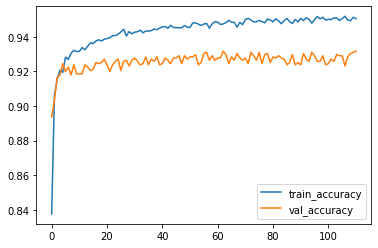

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.legend()

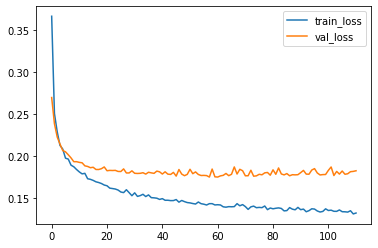

In [9]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

In [10]:
model.evaluate(x_valid, y_valid)

48/48 [==============================] - 4s 68ms/step - loss: 0.1620 - sparse_categorical_accuracy: 0.9363


[0.16200213134288788, 0.9363099336624146]

In [13]:
ratio = 1- (np.count_nonzero(y_train) / y_train.shape[0])

In [14]:
ratio

0.3975705843729481